# Analysis of Experiment 2 (Neuroscience)
In this notebook I will walk through the analysis I did for the second Experiment. There are 4 major sections:
* Preperation and First Look
* Good vs Bad Explanations Overall
* The Conditions
* Neuro Science Language in the Response

## Preperation and First Look

In [1]:
#Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from utils_openAI import *

In [2]:
#read data
df = pd.read_csv('NeuroExp2.csv')
df.shape
df.head()

,Unnamed: 0.1,Unnamed: 0,stimulus_number,condition,good_first,answer
0,0,0,2,With,False,[2]-I choose explanation 2 because it provides...
1,1,0,2,Mixed,False,[2]-I chose explanation 2 because it provides ...
2,2,0,1,Without,False,[2]-I chose explanation 2 because it seems mor...
3,3,0,0,With,False,[2]-I chose this explanation because it makes ...
4,4,0,0,Mixed,False,[2]-I chose explanation 2 because it seems mor...


In [3]:
#get the value count of the different conditions
print(df['condition'].value_counts())
#get value counts of stimulous
print(df['stimulus_number'].value_counts())
#get value counts of answer good
print(df['good_first'].value_counts())

With       136
Mixed      136
Without    128
Name: condition, dtype: int64
2    140
1    134
0    126
Name: stimulus_number, dtype: int64
False    219
True     181
Name: good_first, dtype: int64


Looks good so far. Next, let's clean the data. 

In [4]:
#only keep columns of interest
df = df[['stimulus_number', 'condition', 'answer', 'good_first']]
df['rating'] = df['answer'].str.split('-').str[0] #split at - and take first part as number
df['rating'] = [re.sub("[^0-9-+]", "", df['rating'][i]) for i in range(len(df))] #keep number only
df['rating'] = df['rating'].astype(int) #turn to int
df['explanation_choice'] = df['answer'].str.split('-').str[1] #split at - and take second part as explanation choice
#turn good first numeric
df['good_first_int'] = df['good_first'].astype(int)
#create nueric version of condition
df['condition_num'] = df['condition'].replace({'With': 1, 'Without': 0, 'Mixed': 2})
#create variable indicating whether good condition was picked. It is True if the rating is 1 and good_first is true, or if the rating is 2 and good_first is false, otherwise good_condition is false
df['good_choice'] = np.where((df['rating'] == 1) & (df['good_first_int'] == 1), True, np.where((df['rating'] == 2) & (df['good_first_int'] == 0), True, False))
df['good_choice_int'] = df['good_choice'].astype(int) #turn into numeric as well
#create one hot encoded version of condition
df_ohe = pd.get_dummies(df, columns = ['condition']) #One hot encode conditions in seperate df
df_ohe = pd.get_dummies(df_ohe, columns = ['stimulus_number']) #One hot encode stimulus in seperate df
df_ohe.head()



,answer,good_first,rating,explanation_choice,good_first_int,condition_num,good_choice,good_choice_int,condition_Mixed,condition_With,condition_Without,stimulus_number_0,stimulus_number_1,stimulus_number_2
0,[2]-I choose explanation 2 because it provides...,False,2,I choose explanation 2 because it provides a c...,0,1,True,1,0,1,0,0,0,1
1,[2]-I chose explanation 2 because it provides ...,False,2,I chose explanation 2 because it provides a cl...,0,2,True,1,1,0,0,0,0,1
2,[2]-I chose explanation 2 because it seems mor...,False,2,I chose explanation 2 because it seems more pl...,0,0,True,1,0,0,1,0,1,0
3,[2]-I chose this explanation because it makes ...,False,2,I chose this explanation because it makes more...,0,1,True,1,0,1,0,1,0,0
4,[2]-I chose explanation 2 because it seems mor...,False,2,I chose explanation 2 because it seems more pl...,0,2,True,1,1,0,0,1,0,0


## Good vs Bad Explanations Overall
The first step is to see if there is a difference generally between picking good and bad explanations.

In [5]:
#get the proportion of choosing the good explanation overall
df['good_choice_int'].mean()

0.915

([<matplotlib.patches.Wedge at 0x7f82d8014760>,
 [Text(-1.0610131798703932, 0.29026028343767013, 'Good'),
  Text(1.0610132002524875, -0.2902602089332524, 'Bad')],
 [Text(-0.5787344617474872, 0.15832379096600185, '91.5%'),
  Text(0.578734472864993, -0.15832375032722854, '8.5%')])

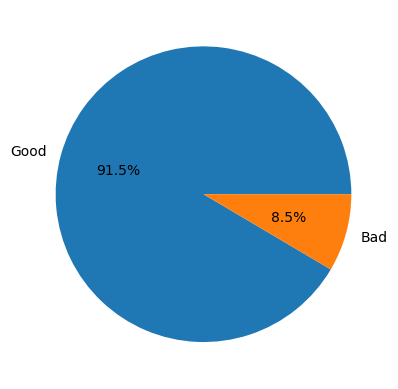

In [6]:
#make a pie graph of the choice of good and bad explantion
plt.pie(df['good_choice_int'].value_counts(), labels = ['Good', 'Bad'], autopct='%1.1f%%')

In [7]:
#test whether the good explanation was chosen more often than chance level
ttest_ind(df['good_choice_int'], [0.5]*len(df))

/var/folders/dv/nfxpqfgn50ncwmnyg61n91m80000gn/T/ipykernel_37443/3377329010.py:2: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(df['good_choice_int'], [0.5]*len(df))


Ttest_indResult(statistic=29.724498401273802, pvalue=2.700442932760826e-131)

In [30]:
#run a logistic regression with condition as predictor and whether the participant picked the good answer as outcome, also add whether they saw the good explanation first as predictor
#logit_model = sm.Logit(df_ohe['good_choice_int'], sm.add_constant(df_ohe[['condition_With', 'condition_Without', 'stimulus_number_0', 'stimulus_number_1', 'good_first_int']])) #reference: Mixed and stim 2
#without int: logit_model = sm.Logit(df_ohe['good_choice_int'], df_ohe[['condition_With', 'condition_Without', 'stimulus_number_0', 'stimulus_number_1', 'good_first_int']]) #reference: Mixed and stim 2
logit_model = sm.Logit(df_ohe['good_choice_int'], sm.add_constant(df_ohe[['condition_With', 'condition_Without', 'good_first_int']])) #reference: Mixed and stim 1 (second)


result = logit_model.fit()
print(result.summary2())
#print table as latex code
print(result.summary2().as_latex())

         Current function value: 0.177125
         Iterations: 35
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.391     
Dependent Variable:     good_choice_int     AIC:                 149.6997  
Date:                   2023-05-03 13:36    BIC:                 165.6655  
No. Observations:       400                 Log-Likelihood:      -70.850   
Df Model:               3                   LL-Null:             -116.33   
Df Residuals:           396                 LLR p-value:         1.3681e-19
Converged:              0.0000              Scale:               1.0000    
No. Iterations:         35.0000                                            
---------------------------------------------------------------------------
                   Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------
const              25.5224 27736.7379  0.0009 0.9993 

/Users/tim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## The Conditions
Here I compare the proportions of choosing the good or bad explanations per condition.

In [9]:
#compare three proportions of choosing the good explanation
prop_with = df[df['condition'] == 'With']['good_choice_int'].mean()
prop_without = df[df['condition'] == 'Without']['good_choice_int'].mean()
prop_mixed = df[df['condition'] == 'Mixed']['good_choice_int'].mean()
print(prop_with, prop_without, prop_mixed)

0.875 1.0 0.875


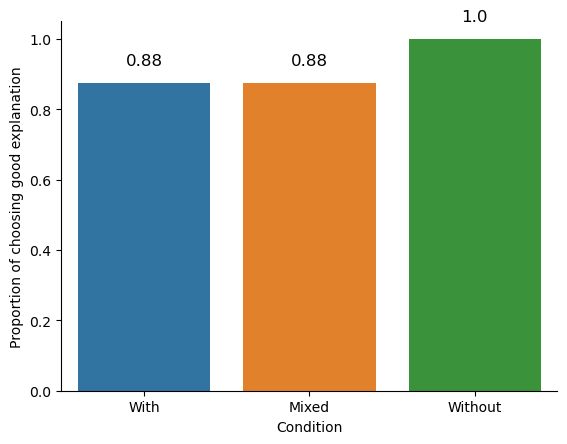

In [28]:
#make three plots
sns.barplot(x = 'condition', y = 'good_choice_int', data = df, ci= None)
#add x and y axis labels
plt.xlabel('Condition')
plt.ylabel('Proportion of choosing good explanation')
#add numeric values to top of bar
plt.text(x = 0, y = df[df['condition_num'] == 1]['good_choice_int'].mean() + 0.05, s = round(df[df['condition_num'] == 1]['good_choice_int'].mean(), 2), size = 12, ha = 'center')
plt.text(x = 1, y = df[df['condition_num'] == 2]['good_choice_int'].mean() + 0.05, s = round(df[df['condition_num'] == 2]['good_choice_int'].mean(), 2), size = 12, ha = 'center')
plt.text(x = 2, y = df[df['condition_num'] == 0]['good_choice_int'].mean() + 0.05, s = round(df[df['condition_num'] == 0]['good_choice_int'].mean(), 2), size = 12, ha = 'center')
#get rid of box around the plot
sns.despine()



In [12]:
#compare proportions 
#non-parametric (Chi-square)
from scipy.stats import chi2_contingency
#make contingency table
contingency_table = pd.crosstab(df['condition'], df['good_choice_int'])
#do chi-square test
c, p, dof, expected = chi2_contingency(contingency_table) 

print('-----Overall-----')
print("Chi-square statistic:", c)
print("DF:", dof)
print("p-value:", p)

#do the same with with vs without
df_subset = df[df['condition'] != 'Mixed']
contingency_table = pd.crosstab(df_subset['condition'], df_subset['good_choice_int'])
#do chi-square test
c, p, dof, expected = chi2_contingency(contingency_table) 

print('-----With vs Without-----')
print("Chi-square statistic:", c)
print("DF:", dof)
print("p-value:", p)

#do the same with with vs mixed
df_subset = df[df['condition'] != 'Without']
contingency_table = pd.crosstab(df_subset['condition'], df_subset['good_choice_int'])
#do chi-square test
c, p, dof, expected = chi2_contingency(contingency_table) 

print('-----With vs Mixed-----')
print("Chi-square statistic:", c)
print("DF:", dof)
print("p-value:", p)

#do the same with Mixed vs without
df_subset = df[df['condition'] != 'With']
contingency_table = pd.crosstab(df_subset['condition'], df_subset['good_choice_int'])
#do chi-square test
c, p, dof, expected = chi2_contingency(contingency_table) 

print('-----Mixed vs Without-----')
print("Chi-square statistic:", c)
print("DF:", dof)
print("p-value:", p)





-----Overall-----
Chi-square statistic: 17.48633879781421
DF: 2
p-value: 0.00015954741632133663
-----With vs Without-----
Chi-square statistic: 15.089364764719894
DF: 1
p-value: 0.00010253936117097967
-----With vs Mixed-----
Chi-square statistic: 0.0
DF: 1
p-value: 1.0
-----Mixed vs Without-----
Chi-square statistic: 15.089364764719894
DF: 1
p-value: 0.00010253936117097967


Potential Issue with One way anova: 
A one-way ANOVA may not be the best statistical test to use for comparing proportions between three conditions because ANOVA assumes that the data is normally distributed and continuous. Proportions, on the other hand, are discrete data and have a specific range of values between 0 and 1.

Instead, use chi-square test of independence, and kruskal wallis test to locate the difference if the chi-square test is significant. This is more appropriate than the fishers test for large sample sizes, which we have. 

## Neuro Science Language in the Response

In [13]:
df_subset = df[df['condition'] != 'Without'] #create subset of with and mixed condition
#create a variable that is 1 if the explanation_choice contains one of the following words: “brain”, “lobe,”, “scan”, “neur*”, “premotor,” “cortex”
df_subset['neuro_used'] = np.where(df_subset['explanation_choice'].str.contains('brain|lobe|scan|neur|premotor|cortex'), 1, 0)

/var/folders/dv/nfxpqfgn50ncwmnyg61n91m80000gn/T/ipykernel_37443/1715165750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['neuro_used'] = np.where(df_subset['explanation_choice'].str.contains('brain|lobe|scan|neur|premotor|cortex'), 1, 0)


In [14]:
#proportion that contains these words
print('----Overall----')
print(df_subset['neuro_used'].mean())
#proportion that contains these words in each condition
print('----By condition----')
print(df_subset.groupby('condition')['neuro_used'].mean())
#proportion that contains these words in for answer good or not
print('----By choosing good answer----')
print(df_subset.groupby('good_choice_int')['neuro_used'].mean())
#proportion by condition and answer
print('----By condition and choosing good answer----')
print(df_subset.groupby(['condition', 'good_choice_int'])['neuro_used'].mean())

----Overall----
0.3786764705882353
----By condition----
condition
Mixed    0.338235
With     0.419118
Name: neuro_used, dtype: float64
----By choosing good answer----
good_choice_int
0    0.558824
1    0.352941
Name: neuro_used, dtype: float64
----By condition and choosing good answer----
condition  good_choice_int
Mixed      0                  1.000000
           1                  0.243697
With       0                  0.117647
           1                  0.462185
Name: neuro_used, dtype: float64
